# Assignment 1

In [1]:
import sys
import nltk
import math
import itertools
import scipy.stats as stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl 
import os.path
from typing import Callable
%matplotlib inline

## Daten einlesen

In [2]:
people_en = pd.read_csv('people_wiki_EN.csv', sep=',')
people_de = pd.read_csv('10k-people-raw.csv', sep=';')

## Hilfsfunktionen

In [3]:
def box_plot(dist, title = None):
    chars = [chr(c) for c in range(ord('a'), ord('z') + 1)]
    
    fig1, ax1 = plt.subplots(figsize = (18, 8))
    ax1.set_xlabel('Character')
    ax1.set_ylabel('Frequency')
    ax1.boxplot(dist, labels = chars)
    ax1.set_ylim([0, 0.3])
    if title is not None:
        plt.title(title)
    plt.show()

In [4]:
def frequency_plot(mean_en, mean_de):
    chars = [chr(c) for c in range(ord('a'), ord('z')+1)]
    ind = np.arange(len(chars))
    width = 1
    frequency = np.log((np.array(mean_en) / np.array(mean_de)))
    color = ['g' if f > 0 else 'b' for f in frequency]
    
    fig, ax = plt.subplots(figsize = (18, 8))
    rects1 = ax.bar(ind, frequency, width, color = color, edgecolor = 'black')
    ax.set_xticklabels(chars)
    ax.set_xticks(ind + (width * 0.5) - 0.5)
    ax.set_xlabel('Character')
    ax.set_ylim([-2, 2])
    ax.set_ylabel('F')
    ax.set_xlim([-0.5, len(chars) - 0.5])
    ax.text(1, 1.5, 'More frequent in English ', bbox={'facecolor':'green', 'alpha':0.5, 'pad':10})
    ax.text(1, 1.2, 'More frequent in German', bbox={'facecolor':'blue', 'alpha':0.5, 'pad':10})
    ax.text(5.5, 1.35, r'$F = \ln(\frac{mean_e}{mean_d})$', fontsize=25)
    plt.show()

In [5]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Greens):
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm[np.isnan(cm_norm)] = 0
    cm_norm = np.around(cm_norm, decimals = 3)
        
    plt.imshow(cm_norm, interpolation='nearest', cmap = cmap)
    
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
def load_np(file: str, func) -> np.ndarray:
    if not os.path.isfile(file):
        return func()
    else:
        return np.load(file)


def load_np_distribution(
        mean: str, 
        std: str, 
        dist: str,  
        func
        ) -> (np.ndarray, np.ndarray, np.ndarray):
    if not os.path.isfile(mean):
        return func()
    else:
        return np.load(mean), np.load(std), np.load(dist)

## Häufigkeitsverteilungen

In [7]:
def get_letters() -> [str]:
    return [chr(i) for i in range(ord('a'), ord('z') + 1)]


def get_chars(text: str) -> [str]:
    return [char.lower() for char in text if char.lower() in get_letters()]


def character_distribution(people: [str]) -> (np.ndarray, np.ndarray, np.ndarray):
    mean = np.zeros(shape=26)
    std = np.zeros(shape=26)
    dist = np.ones(shape=(len(people), 26))

    for i, text in enumerate(people):
        fdist = nltk.FreqDist(get_chars(text))
        dist[i, :] = [fdist.freq(c) for c in get_letters()]

    for i in range(0, 26):
        std[i] = dist[:, i].std()
        mean[i] = dist[:, i].mean()

    return mean, std, dist

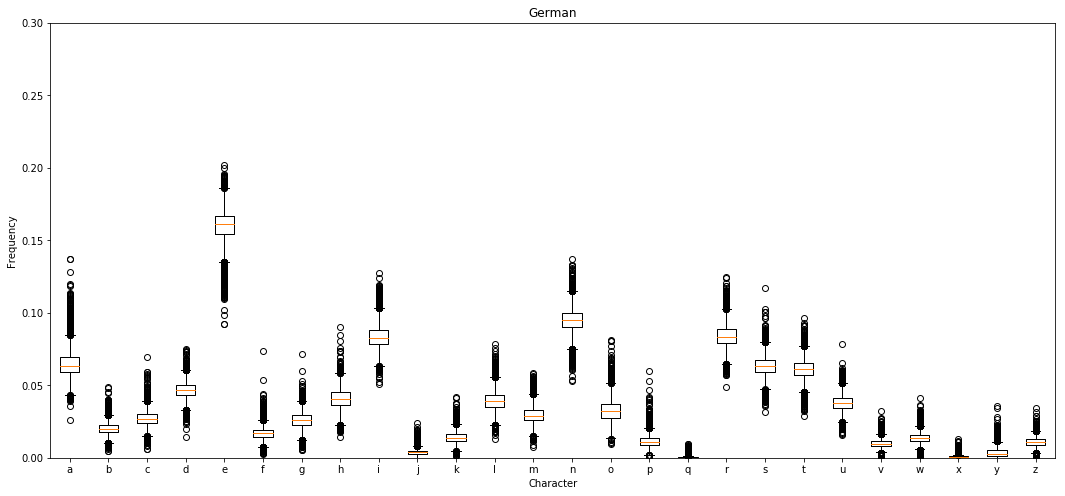

In [8]:
mean_de, std_de, dist_de = load_np_distribution('mean_de.npy', 'std_de.npy', 'dist_de.npy', 
                                                lambda: character_distribution(people_de['text']))
# mean_de, std_de, dist_de = character_distribution(people_de['text'])
box_plot(dist_de, 'German')

np.save('mean.de.npy', mean_de)
np.save('std_de.npy', std_de)
np.save('dist_de', dist_de) 

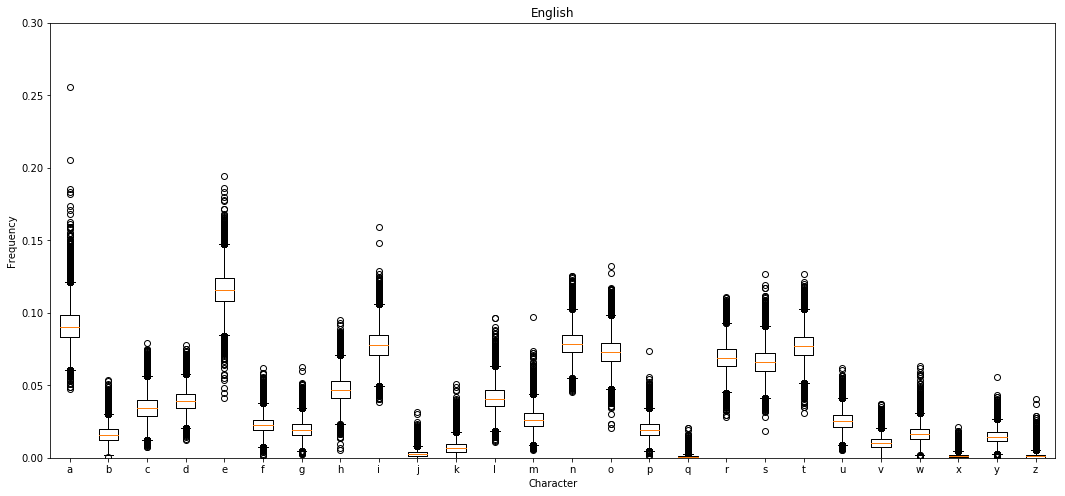

In [9]:
mean_en, std_en, dist_en = load_np_distribution('mean_en.npy', 'std_en.npy', 'dist_en.npy', 
                                                lambda: character_distribution(people_en['text']))
# mean_en, std_en, dist_en = character_distribution(people_en['text'])
box_plot(dist_en, 'English')

np.save('mean_en.npy', mean_en)
np.save('std_en.npy', std_en)
np.save('dist_en', dist_en)

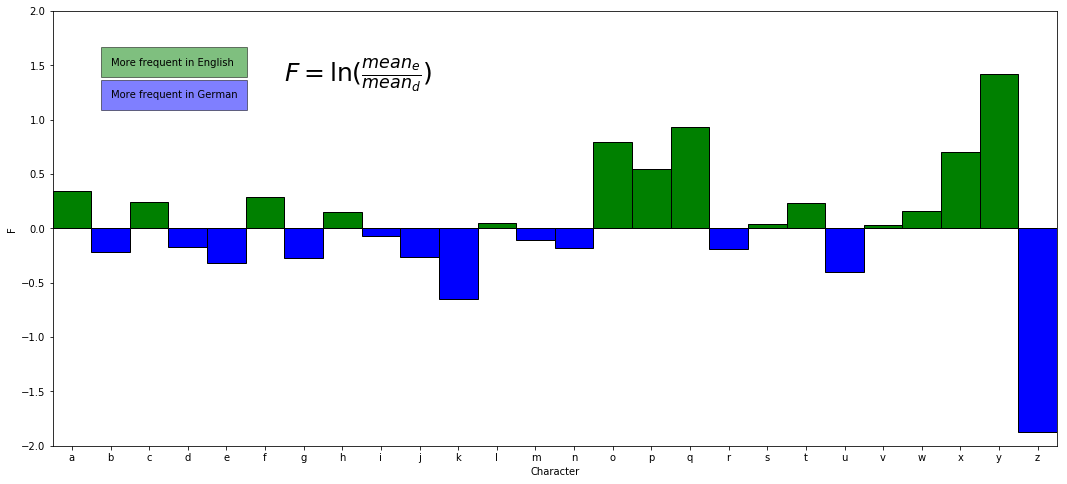

In [10]:
frequency_plot(mean_en, mean_de)

## Spracherkennung

In [11]:
def z(x, mean, std):
    return (x - mean)/std

def calc_p(mean: np.ndarray, std: np.ndarray, dist: np.ndarray) -> float:
    p = np.abs(mean - dist) < std
    return p.sum() / p.shape[0]


def calc_p2(mean: np.ndarray, std: np.ndarray, dist: np.ndarray) -> float:
    #p = stats.norm.logpdf(dist, mean, std)
    p = np.log(stats.norm.pdf(dist, mean, std) + 1e-7)
    #p = stats.norm.pdf(z(dist, mean, std))
    #p = np.abs(stats.norm.pdf(dist, mean, std) - stats.norm.pdf(mean, mean, std))
    return p.sum()


def plot_p(p_de: [float], p_en: [float], epsilon: float):
    fig, ax = plt.subplots(figsize = (18, 8))
    ind = np.arange(len(p_de))
    width = 1
    
    rects1 = ax.bar(ind, p_de, width, color = 'blue', alpha=0.6)
    rects2 = ax.bar(ind, p_en, width, color = 'green', alpha=0.6)
    line = ax.plot(ind, np.full((len(p_de)), epsilon), 'y--')
    ax.set_xlabel('Texts')
    ax.set_ylabel('P')
    #ax.set_ylim([-20, 50])
    plt.legend([rects1, rects2], ['German', 'English'])
    plt.show()
    
    
class language_detector:
    def __init__(self,
                 mean_de: np.ndarray, 
                 std_de: np.ndarray, 
                 mean_en: np.ndarray, 
                 std_en: np.ndarray,
                 epsilon: float = 10,
                 mean_freq_threshold: float = 0.5,
                 mask: np.ndarray = None):
        self.mean_de = mean_de
        self.std_de = std_de
        self.mean_en = mean_en
        self.std_en = std_en
        self.epsilon = epsilon
        self.mean_freq_threshold = mean_freq_threshold
        self.lang = []
        self.p_des = []
        self.p_ens = []
        self.mask = mask
    
    def determine_language(self, texts: [str]):
        del self.lang[:]
        del self.p_des[:]
        del self.p_ens[:]
        
        dist = np.zeros(shape=26)

        mean_freq = np.abs(self.mean_de / self.mean_en - 1)
        freq_bool = mean_freq > self.mean_freq_threshold
        freq_bool = self.mask
        
        freq_bool = self.__find_best_letters()

        for i in range(texts.shape[0]):
            fdist = nltk.FreqDist(get_chars(texts[i]))

            dist[:] = [fdist.freq(c) for c in get_letters()]

            p_de = calc_p2(mean_de[freq_bool], std_de[freq_bool], dist[freq_bool])
            p_en = calc_p2(mean_en[freq_bool], std_en[freq_bool], dist[freq_bool])

            self.p_des.append(p_de)
            self.p_ens.append(p_en)

            if p_de > p_en and p_de > epsilon:
                self.lang.append('G')
            elif p_en > p_de and p_en > epsilon:
                self.lang.append('E')
            else:
                self.lang.append('X')
    
    def __find_best_letters(self):
        b1 = self.std_de < 0.01
        b2 = self.std_en < 0.01
        mean_freq = np.abs(self.mean_de / self.mean_en-1)
        freq_bool = mean_freq > self.mean_freq_threshold
        b3 = np.bitwise_and(b1, b2)
        b4 = np.bitwise_and(b3, freq_bool)

        letters = np.array(get_letters())
        print("used letter: ", letters[b4])
        return b4
    
    def plot_p_distribution(self):
        plot_p(self.p_des, self.p_ens, self.epsilon)
        
    def cm(self, true_labels):
        cm = confusion_matrix(true_labels, self.lang)
        plot_confusion_matrix(cm, ['English', 'German', 'X'])
        return cm
    
    def print_accuracy(self, cm):
        print('Accuracy:', accuracy(cm))

In [12]:
def accuracy(cm):
    i = np.eye(cm.shape[0])
    return (i * cm).sum() / cm.sum()

In [13]:
b1 = std_de < 0.009
b2 = std_en < 0.009
mean_freq = np.abs(mean_de / mean_en-1)
freq_bool = mean_freq > 0.5
b3 = np.bitwise_and(b1, b2)
b4 = np.bitwise_and(b3, freq_bool)

letters = np.array(get_letters())
print("used letter: ", letters[b4])


print(b4)

used letter:  ['k' 'q' 'x' 'y' 'z']
[False False False False False False False False False False  True False
 False False False False  True False False False False False False  True
  True  True]


In [14]:
ind = np.linspace(-1, 1, num=1000)
#pdf_de = stats.norm.pdf(z(ind, mean_de[0], std_de[0]))
#pdf_en = stats.norm.pdf((ind - mean_en[0]) / std_en[0])
letters = get_letters()

surface = np.zeros(shape=(26))

for i in range(0, 26):
    print(letters[i])
    #pdf_de = stats.norm.pdf(z(ind, mean_de[i], std_de[i]))
    #pdf_en = stats.norm.pdf(z(ind, mean_en[i], std_en[i]))
    pdf_de = stats.norm.pdf(z(ind, mean_de[i], std_de[i]))
    pdf_en = stats.norm.pdf(z(ind, mean_en[i], std_en[i]))
    pdf_mul = pdf_de * pdf_en
    
    surface[i] = pdf_mul.sum()

    #fig, ax = plt.subplots(figsize = (18, 8))
    #line1 = ax.plot(ind, pdf_de, 'b')
    #line2 = ax.plot(ind, pdf_en, 'g')
    #line3 = ax.plot(ind, pdf_mul, 'y')
    #plt.show()

    
print(std_de)
    
print([letters[c] for c in surface.argsort()[:-15]])
choosen = surface.argsort()[-15:]
mask = np.zeros((26), dtype=bool)

for c in choosen:
    mask[c] = True

a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
[0.00879024 0.00407719 0.00494753 0.00552759 0.01060253 0.004034
 0.00522911 0.00687124 0.00801391 0.00206936 0.0039319  0.00656572
 0.00563178 0.00801954 0.00751848 0.00400742 0.00061482 0.00762328
 0.00672792 0.00644932 0.00540861 0.00273986 0.00349948 0.00095575
 0.00331112 0.00314444]
['o', 'z', 'e', 'y', 'q', 'x', 'u', 'a', 'k', 'j', 'p']


In [90]:
people_test = pd.read_csv('Language_test.csv', sep=';', quotechar='|')
lang_true = np.array(people_test['language'])

#epsilon = 30
#mean_freq_threshold = 0.2
epsilon = 20
mean_freq_threshold = 0.2
detector = language_detector(mean_de, std_de, mean_en, std_en, epsilon=epsilon, mean_freq_threshold=mean_freq_threshold, mask=mask)

used letter:  ['b' 'c' 'f' 'g' 'j' 'k' 'n' 'o' 'p' 'q' 'r' 't' 'u' 'x' 'y' 'z']


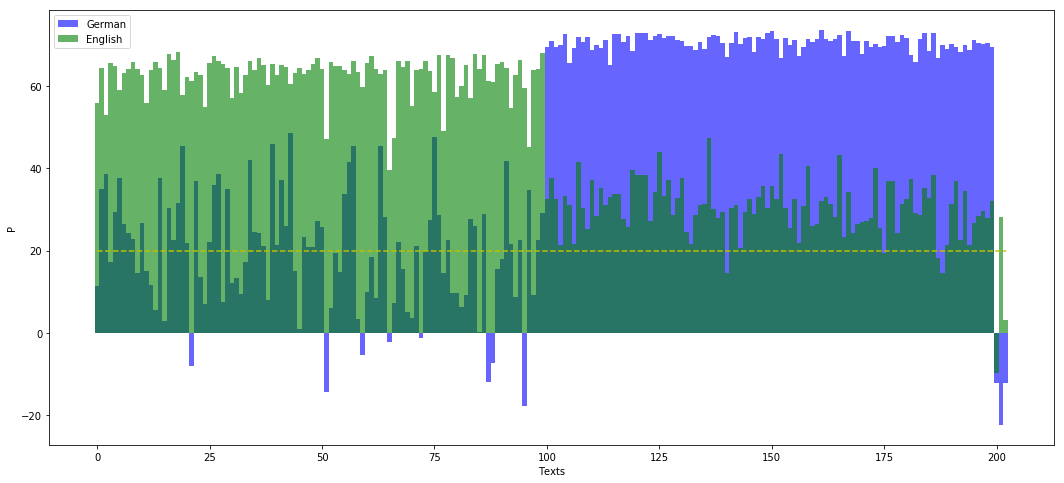

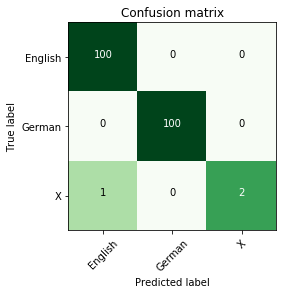

Accuracy: 0.9950738916256158


In [91]:
detector.determine_language(people_test['text'])
detector.plot_p_distribution()
cm = detector.cm(lang_true)
detector.print_accuracy(cm)

used letter:  ['b' 'c' 'f' 'g' 'j' 'k' 'n' 'o' 'p' 'q' 'r' 't' 'u' 'x' 'y' 'z']


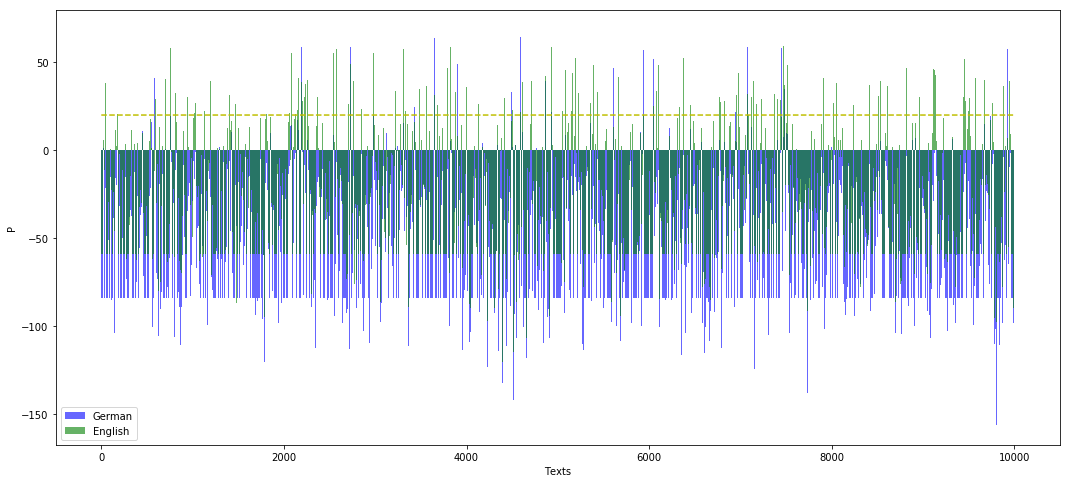

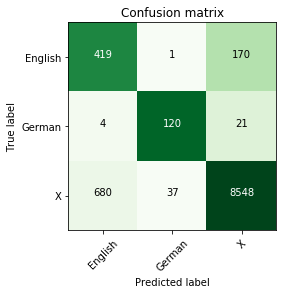

Accuracy: 0.9087


In [92]:
old_newspaper = np.load('old_newpaper.npy')
old_newspaper_true = old_newspaper[:, 0]

detector.determine_language(old_newspaper[:, 1])
detector.plot_p_distribution()
cm = detector.cm(old_newspaper_true)
detector.print_accuracy(cm)

used letter:  ['b' 'c' 'f' 'g' 'j' 'k' 'n' 'o' 'p' 'q' 'r' 't' 'u' 'x' 'y' 'z']


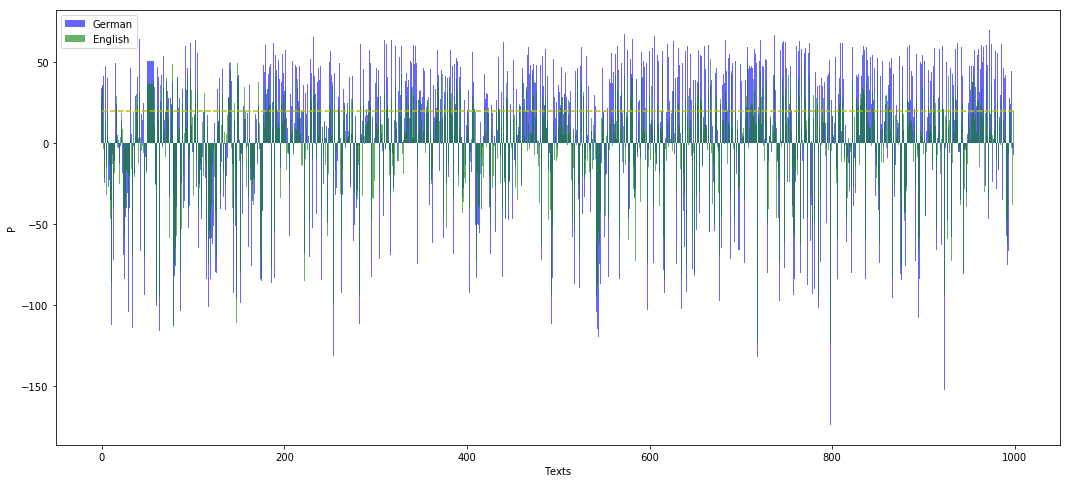

I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


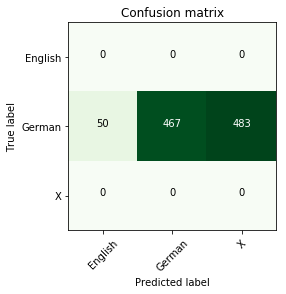

Accuracy: 0.467


In [93]:
people_test_german_only = np.load('german_only.npy')
lang_true_german_only = people_test_german_only[:, 0]

detector.determine_language(people_test_german_only[:, 1])
detector.plot_p_distribution()
cm = detector.cm(lang_true_german_only)
detector.print_accuracy(cm)

used letter:  ['b' 'c' 'f' 'g' 'j' 'k' 'n' 'o' 'p' 'q' 'r' 't' 'u' 'x' 'y' 'z']


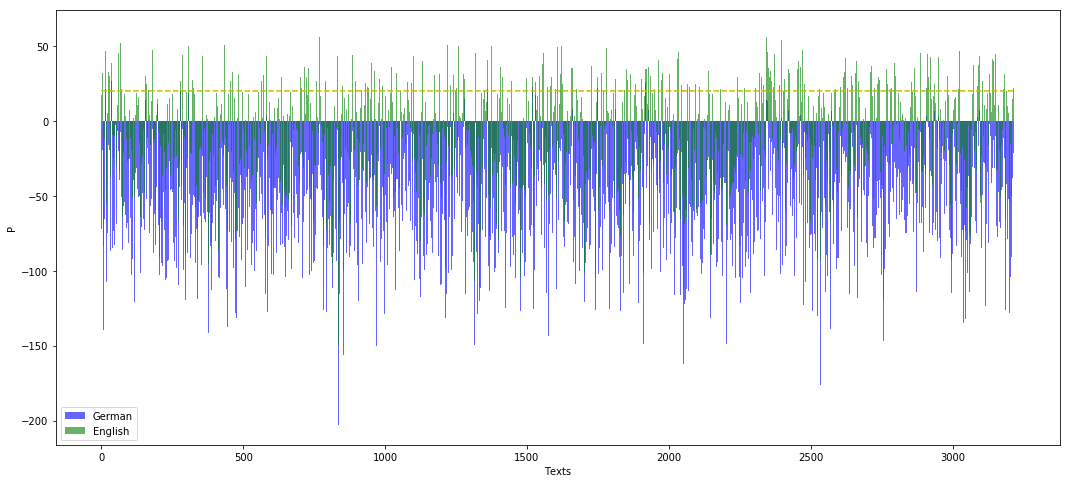

I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


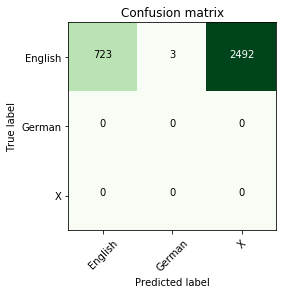

Accuracy: 0.22467371037911746


In [94]:
elonmusk_tweets = np.load('elonmusk_tweets.npy')
elon_true = elonmusk_tweets[:, 0]

detector.determine_language(elonmusk_tweets[:, 1])
detector.plot_p_distribution()
cm = detector.cm(elon_true)
detector.print_accuracy(cm)

## Neural Network

### Preprocessing

In [19]:
import keras
import re

def character_distribution_nn(people: [str]) -> np.ndarray:
    x = np.zeros(shape=(len(people), 26))
    
    for i, text in enumerate(people):
        fdist = nltk.FreqDist(get_chars(text))        
        x[i, :] = [fdist.freq(c) for c in get_letters()]
    return x


def preprocess_for_rnn(people: [str]) -> np.ndarray:
    x = keras.preprocessing.sequence.pad_sequences(people, maxlen=200, padding='pre', value=0)
    x_shaped = x.reshape(x.shape[0], x.shape[1], 1)
    return x_shaped
    

def process_sentence(sentence):
    return re.sub(r'[\\\\/:*«`\'?¿";!<>,.|]', '', sentence.lower().strip())



I:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
x_de = load_np('x_de.npy', lambda: character_distribution_nn(people_de['text']))

# if not os.path.isfile('x_de.npy'):
#     x_de = character_distribution_nn(people_de['text'])
#     np.save('x_de.npy', x_de)
# else:
#     x_de = np.load('x_de.npy')

In [21]:
x_en = load_np('x_en.npy', lambda: character_distribution_nn(people_en['text']))

# if not os.path.isfile('x_en.npy'):
#     x_en = character_distribution_nn(people_en['text'])
#     np.save('x_en.npy', x_en)
# else:
#     x_en = np.load('x_en.npy')

In [22]:
x_train = np.vstack((x_de, x_en))
y_train = np.vstack((np.zeros(shape=(x_de.shape[0], 1)), np.ones(shape=(x_en.shape[0], 1))))

rand = np.random.permutation(x_train.shape[0])
x_train = x_train[rand]
y_train = y_train[rand]

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)

sentences = people_de['text'].apply(process_sentence)
words = [sentence for sentence in sentences]
print(words[:2])
#print(preprocess_for_rnn(people_de['text']))

x_train:  (69071, 26)
y_train:  (69071, 1)
['wallenstein eigentlich albrecht wenzel eusebius von waldstein tschechisch albrecht václav eusebius z valdštejna (\xa024\xa0september\xa01583 in hermanitz an der elbe böhmen † 25 februar 1634 in eger böhmen) war ein böhmischer feldherr und politiker er war herzog von friedland und sagan von 1628 bis 1631 als albrecht viii herzog zu mecklenburg fürst zu wenden graf von schwerin herr von rostock herr von stargard und als generalissimus zwischen 1625 und 1634 zweimal oberbefehlshaber der kaiserlichen armee im dreißigjährigen krieg er kämpfte auf seiten des kaisers und der katholischen liga gegen die protestantischen mächte deutschlands sowie gegen dänemark und schweden fiel jedoch später in ungnade und wurde von kaisertreuen offizieren ermordet  jugend albrecht wenzel eusebius genannt wallenstein wurde am 24\xa0september 1583 in hermanitz an der elbe geboren er entstammte dem alten böhmischen herrengeschlecht von waldstein wallensteins großvater

### Training

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

y_binary = to_categorical(y_train)
model = Sequential()

model.add(Dense(units=120, input_dim=26))
model.add(Dropout(0.2))
model.add(Dense(units=240, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=240, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_binary, epochs=7, batch_size=50, verbose=2)

Epoch 1/7
 - 13s - loss: 0.4182 - acc: 0.8549
Epoch 2/7
 - 6s - loss: 0.3794 - acc: 0.8552
Epoch 3/7
 - 7s - loss: 0.2446 - acc: 0.8841
Epoch 4/7
 - 7s - loss: 0.0627 - acc: 0.9921
Epoch 5/7
 - 7s - loss: 0.0229 - acc: 0.9975
Epoch 6/7
 - 7s - loss: 0.0142 - acc: 0.9982
Epoch 7/7
 - 7s - loss: 0.0109 - acc: 0.9982


### Prediction

In [24]:
def determine_language_nn(texts: [str]) -> [str]:
    lang = []
    ps = []
    
    for k, text in enumerate(texts):
        x_data = np.zeros(shape=(1, 26))
        fdist = nltk.FreqDist(get_chars(text))
        x_data[0, :] = [fdist.freq(c) for c in get_letters()]
        p = model.predict(x_data)
        ps.append(p)
        
        if p[0, 0] > 0.95:
            lang.append('G')
        elif p[0, 1] > 0.95:
            lang.append('E')
        else:
            lang.append('X')
            
    return lang

Accuracy: 0.9852216748768473


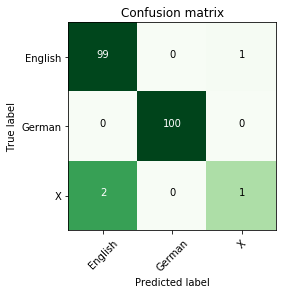

In [25]:
lang = determine_language_nn(people_test['text'])
cm = confusion_matrix(lang_true, lang)
print('Accuracy:', accuracy(cm))
plot_confusion_matrix(cm, ['English', 'German', 'X'])

Accuracy: 0.741


I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


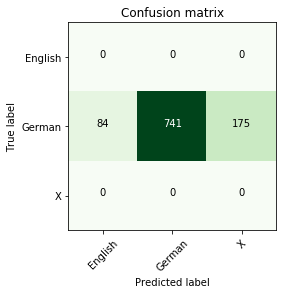

In [26]:
people_test_german_only = np.load('german_only.npy')

lang = determine_language_nn(people_test_german_only[:, 1])
lang_true_german_only = people_test_german_only[:, 0]
cm = confusion_matrix(lang_true_german_only, lang)
print('Accuracy:', accuracy(cm))
plot_confusion_matrix(cm, ['English', 'German', 'X'])

Accuracy: 0.870105655686762


I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


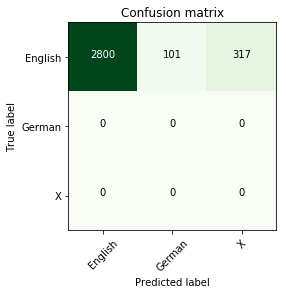

In [27]:
elonmusk_tweets = np.load('elonmusk_tweets.npy')

lang = determine_language_nn(elonmusk_tweets[:, 1])
lang_true_german_only = elonmusk_tweets[:, 0]
cm = confusion_matrix(lang_true_german_only, lang)
print('Accuracy:', accuracy(cm))
plot_confusion_matrix(cm, ['English', 'German', 'X'])